In [56]:
import os
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm.notebook import tqdm
from collections import defaultdict

os.chdir("/afs/csail.mit.edu/u/s/samsl/Work/Adapting_PLM_DTI")
data_dir = "/afs/csail.mit.edu/u/s/samsl/Work/databases/GalanLandscape/"

In [12]:
supp1 = pd.read_excel(f"{data_dir}/journal.pone.0247018.s001.xlsx",header=3)
supp3 = pd.read_excel(f"{data_dir}/journal.pone.0247018.s003.xlsx",header=3)

In [14]:
import xml.etree.ElementTree as ET
full_drugbank = ET.parse('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/full_database.xml')
drugbank_root = full_drugbank.getroot()
namespaces = {'drugbank': 'http://www.drugbank.ca'}

In [51]:
molecules = Chem.SDMolSupplier('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/all_structures.sdf')
moleculeDict = {m.GetProp('DRUGBANK_ID'): m for m in molecules if m is not None}

[10:13:16] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[10:13:16] ERROR: Could not sanitize molecule ending on line 289199
[10:13:16] ERROR: Explicit valence for atom # 13 Cl, 5, is greater than permitted
[10:13:16] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:13:16] ERROR: Could not sanitize molecule ending on line 399275
[10:13:16] ERROR: Explicit valence for atom # 19 O, 3, is greater than permitted
[10:13:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:13:16] ERROR: Could not sanitize molecule ending on line 522730
[10:13:16] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[10:13:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:13:16] ERROR: Could not sanitize molecule ending on line 578040
[10:13:16] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[10:13:16] Explicit valence for atom # 12 N, 4, is greater than permitted
[10:13:16] ERROR: Could not sanitize

In [91]:
cnDict = defaultdict()
dbDict = defaultdict()

for drxml in tqdm(drugbank_root, total=len(drugbank_root)):
    dbid = drxml.find('drugbank:drugbank-id[@primary="true"]',namespaces).text
    commonname = drxml.find('drugbank:name',namespaces).text
    if dbid in moleculeDict.keys():
        cnDict[commonname] = moleculeDict[dbid].GetProp('SMILES')
        
    else:
        continue

  0%|          | 0/14594 [00:00<?, ?it/s]

In [96]:
supp3.head()

,Node,Community ID
0,Nitisinone,186
1,4-hydroxyphenylpyruvate_dioxygenase,186
2,Pyrazinamide,185
3,Fatty_acid_synthetase_I_(FASI),185
4,Ethambutol,184


In [110]:
communities = supp3[supp3['Node'].isin(cnDict.keys())]

In [111]:
communities

,Node,Community ID
0,Nitisinone,186
2,Pyrazinamide,185
4,Ethambutol,184
8,Dapsone,183
22,Lixisenatide,181
...,...,...
4857,Floxuridine,0
4858,Tioguanine,0
4859,Sulfadiazine,0
4860,Grepafloxacin,0


In [113]:
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding
# Load model
device = torch.device(6)
drug_f = MorganFeaturizer().cuda(device)
target_f = ProtBertFeaturizer().cuda(device)
model = SimpleCoembedding(drug_f.shape, target_f.shape, 1024)
model.load_state_dict(torch.load("best_models/reverse_margin_best_model.pt"))
model = model.to(device)

In [245]:
cnEmbeddings = {}
cnMorgan = {}

for _, r in communities.iterrows():
    morg = drug_f(cnDict[r.Node])
    cnEmbeddings[r.Node] = model.drug_projector(morg.unsqueeze(0)).squeeze().detach().cpu().numpy()
    cnMorgan[r.Node] = morg.detach().cpu().numpy()

In [274]:
from sklearn.manifold import TSNE

cnEmbeddings_np = np.stack(cnEmbeddings.values())
cnMorgan_np = np.stack(cnMorgan.values())
embed_tsne = TSNE(metric="cosine").fit_transform(cnEmbeddings_np)
morgan_tsne = TSNE().fit_transform(cnMorgan_np)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 t

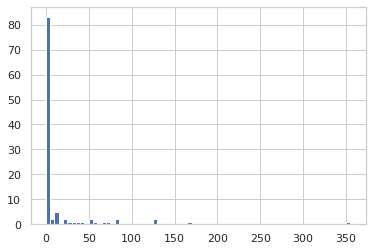

1373


In [294]:
comm_count = communities.groupby('Community ID').count().sort_values(by='Node',ascending=False)

plt.hist(comm_count,bins=np.arange(0,360,5))
plt.show()

keep_mask = communities['Community ID'].isin(comm_count[comm_count['Node'] >= 25].index)
communities_small = communities[keep_mask]
embeddings_small = embed_tsne[keep_mask,:]
morgan_small = morgan_tsne[keep_mask,:]

print(len(communities_small))

In [295]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
silscore_m = silhouette_score(morgan_small, communities_small['Community ID'])
silscore_e = silhouette_score(embeddings_small, communities_small['Community ID'])
print(silscore_m, silscore_e)

-0.1562475 -0.14007749


15


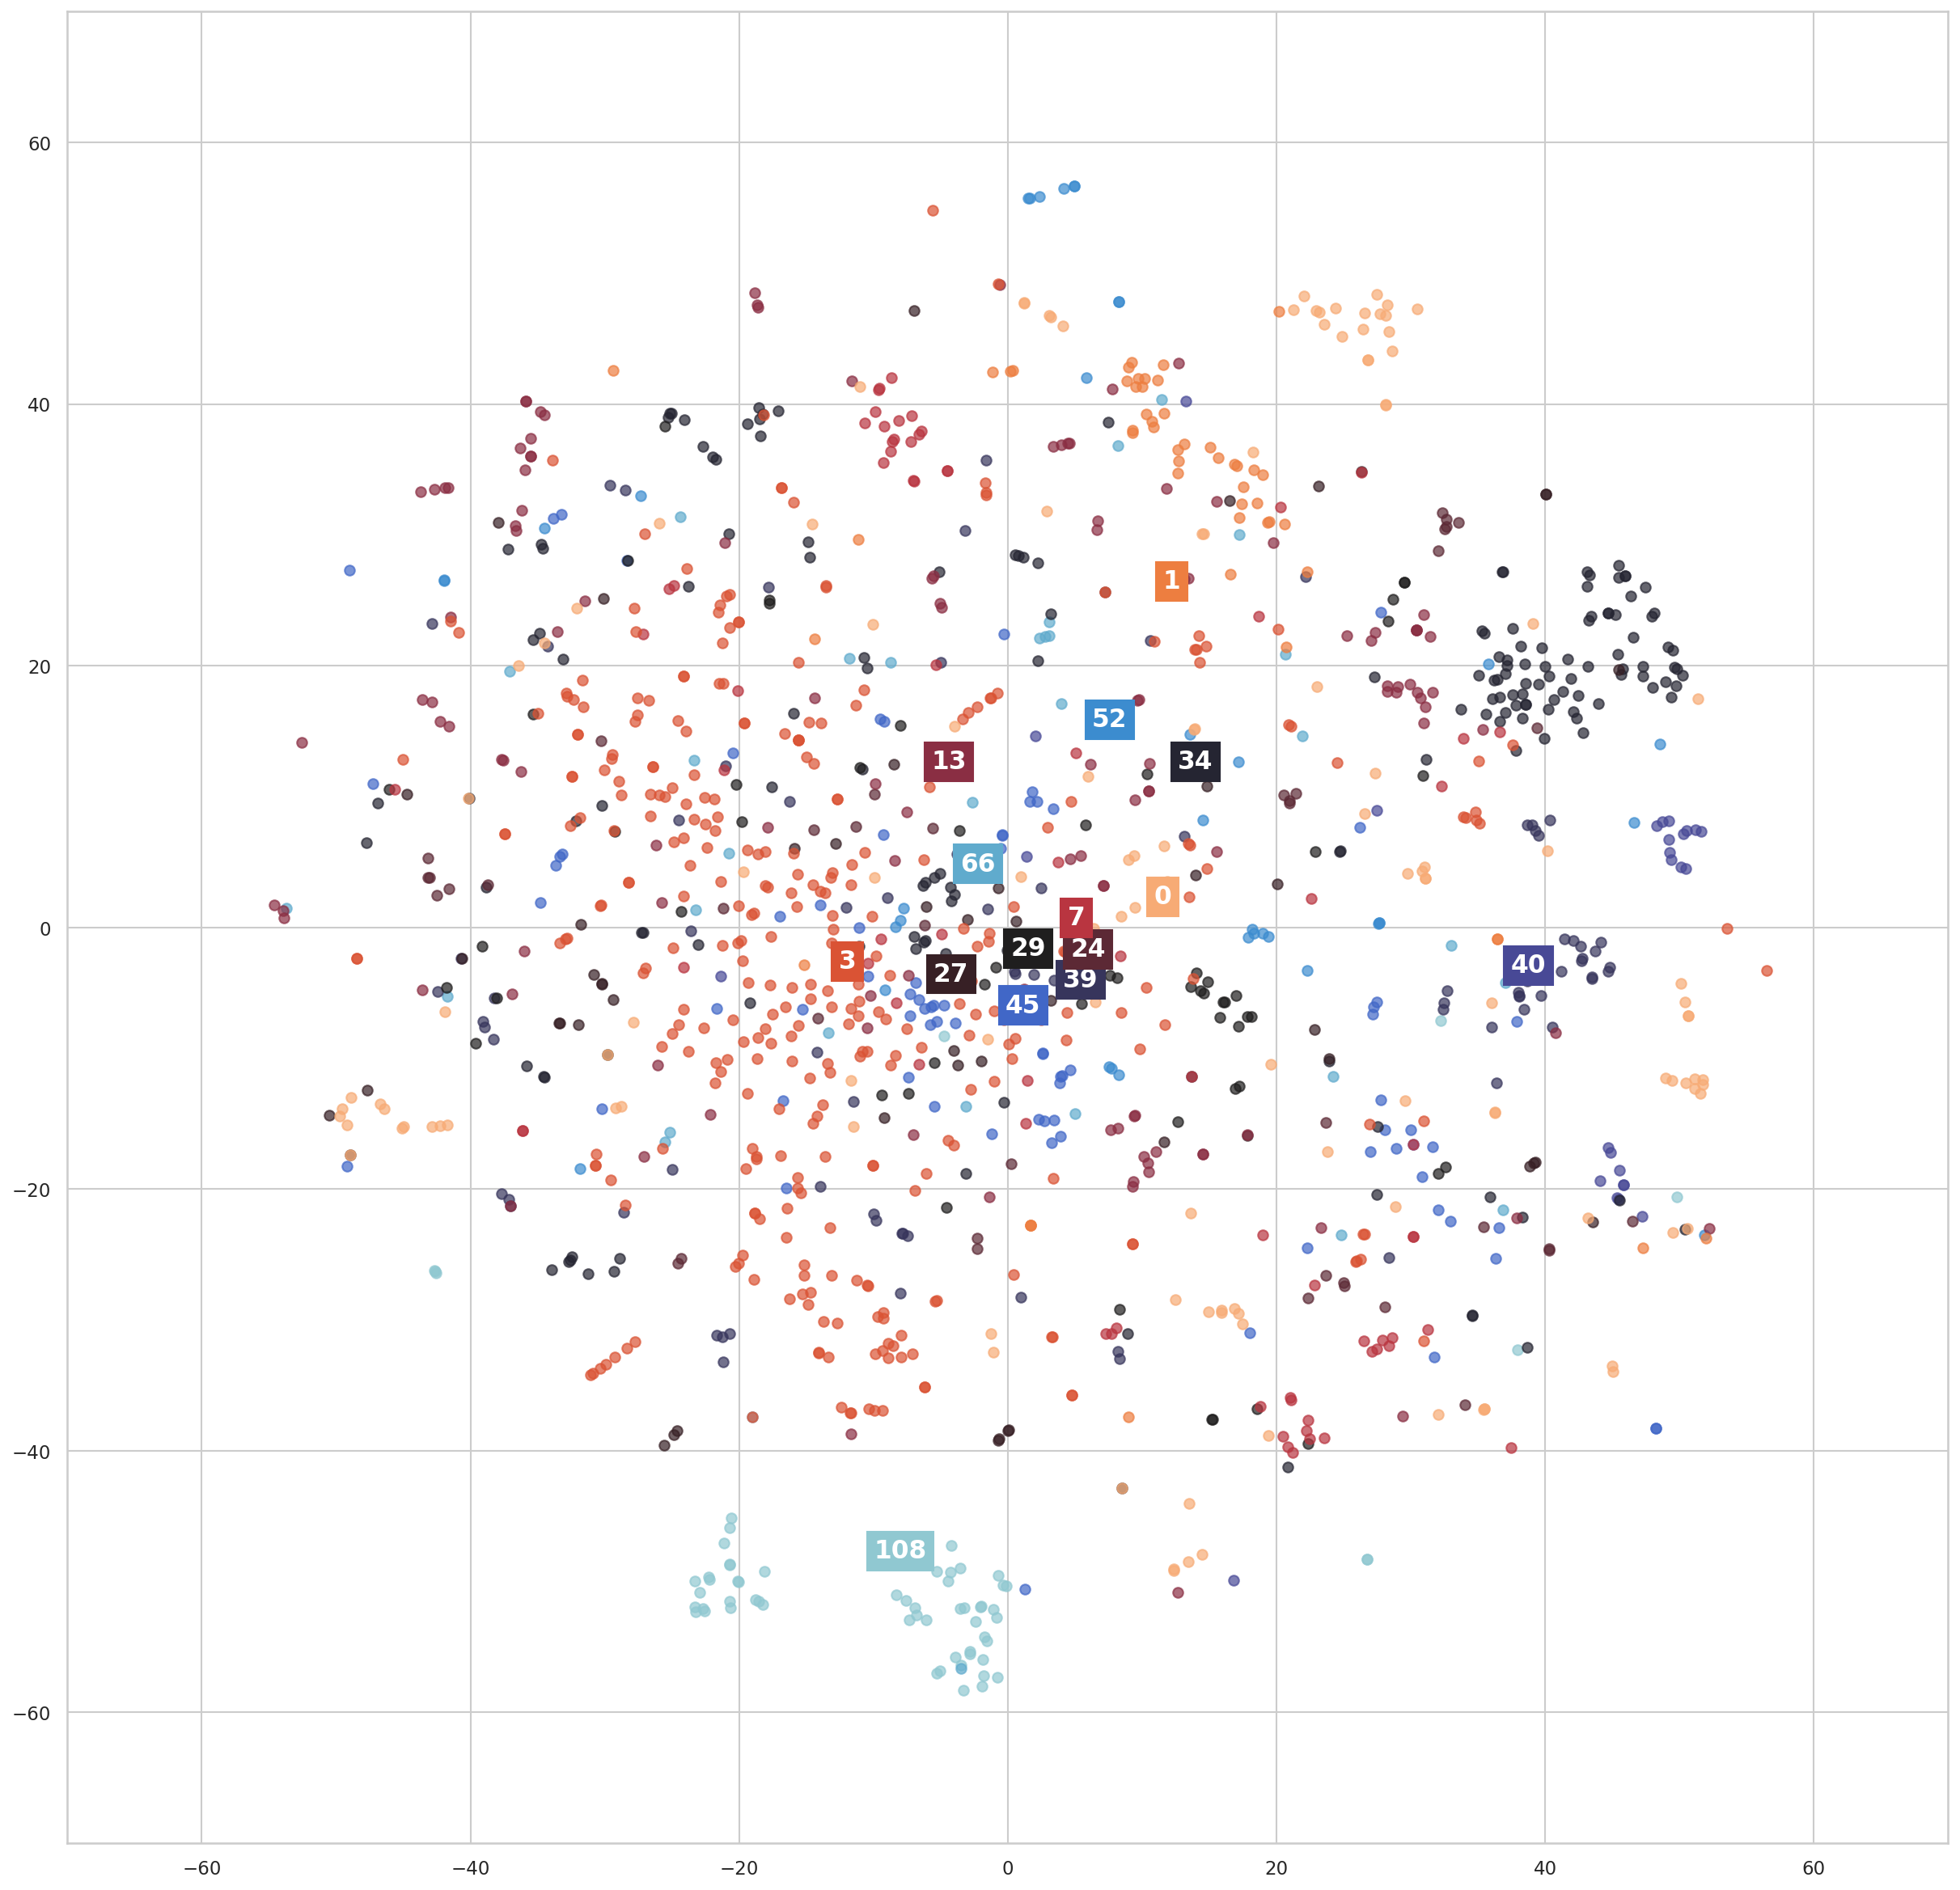

In [296]:
sns.set(style='whitegrid',font_scale=1)
plt.figure(figsize=(20, 20), dpi=150)

style = communities_small['Community ID']
print(len(style.unique()))
customPalette = sns.color_palette('icefire', len(style.unique()))

data = pd.DataFrame({
    'x': embeddings_small[:,0],
    'y': embeddings_small[:,1],
    'Community': style
})

for i, label in enumerate(style.unique()):
# for i, label in [(0,108)]:
    # i = list(style.unique()).index(label) % 10
    
    xmean = data.loc[data['Community']==label, 'x'].mean()
    ymean = data.loc[data['Community']==label,'y'].mean()

    #add data points 
    plt.scatter(x=data.loc[data['Community']==label, 'x'], 
                y=data.loc[data['Community']==label,'y'], 
                color=customPalette[i], 
                alpha=0.7)

    #add label
    plt.annotate(label, 
                 (xmean, ymean),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=15, weight='bold',
                 color='white',
                 backgroundcolor=customPalette[i])
    
plt.xlim(-70,70)
plt.ylim(-70,70)
plt.show()

In [297]:
communities[communities['Community ID'] == 108]

,Node,Community ID
394,Ampicillin,108
402,Phenoxymethylpenicillin,108
406,Cefpiramide,108
410,Ceftazidime,108
413,Loracarbef,108
...,...,...
514,Cefmetazole,108
515,Flucloxacillin,108
516,Ertapenem,108
517,Piperacillin,108
